In [45]:
## Installation
source("https://bioconductor.org/biocLite.R")
biocLite('edgeR','limma')
library(limma)
library(edgeR)

Bioconductor version 3.6 (BiocInstaller 1.28.0), ?biocLite for help
BioC_mirror: https://bioconductor.org
Using Bioconductor 3.6 (BiocInstaller 1.28.0), R 3.4.2 (2017-09-28).
Installing package(s) 'edgeR'
Warning message:
"package 'edgeR' is in use and will not be installed"Old packages: 'backports', 'digest', 'GenomeInfoDbData', 'htmlTable',
  'RcppArmadillo', 'reshape2', 'yaml', 'broom', 'caret', 'curl', 'data.table',
  'foreach', 'glue', 'hms', 'iterators', 'lazyeval', 'lubridate', 'Matrix',
  'odbc', 'openssl', 'profvis', 'pryr', 'purrr', 'quantmod', 'Rcpp', 'recipes',
  'rlang', 'rmarkdown', 'robustbase', 'sparklyr', 'stringi', 'tidyr',
  'tidyselect', 'tidyverse', 'timeDate', 'withr'


In [84]:
## Loading Data
filename_in <- '../../data/TissueMap/PRJNA347821_U2OS+IMR90.count.txt'

sample1 <- 'U2OS'
sample2 <- 'IMR90'
min_cpm1 <- 3

filename_base <- sub('.count.txt','',filename_in)

sample_label <- paste(sample1,sample2,sep='-')
filename_edgeR_cpm <- paste(filename_base, 'edgeR_cpm','txt',sep='.')
filename_edgeR_out <- paste(filename_base, sample_label, 'edgeR_out','txt', sep='.')
filename_limma_out <- paste(filename_base, sample_label, 'limma_out','txt', sep='.')

x <- read.delim(filename_in,row.names='SeqID',header=T)
groups <- gsub('_[123]$','',colnames(x))
sample_names <- colnames(x)

print(c(filename_edgeR_cpm, filename_edgeR_out, filename_limma_out))

[1] "../../data/TissueMap/PRJNA347821_U2OS+IMR90.edgeR_cpm.txt"           
[2] "../../data/TissueMap/PRJNA347821_U2OS+IMR90.U2OS-IMR90.edgeR_out.txt"
[3] "../../data/TissueMap/PRJNA347821_U2OS+IMR90.U2OS-IMR90.limma_out.txt"


In [50]:
## Filtering
cpm <- cpm(x)
lcpm <- cpm(x, log=TRUE)

keep <- rowSums(cpm(x)>1) > ncol(x)/2
x_filtered <- x[keep,]

cpm_filterd <- cpm(x_filtered)
lcpm_filtered <- cpm(x_filtered, log=TRUE)

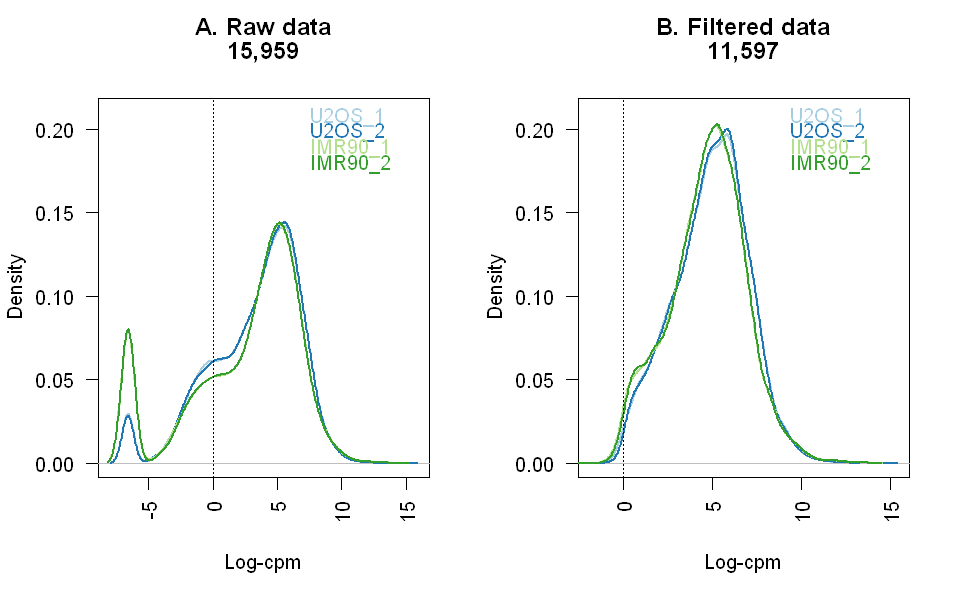

In [51]:
## Density Plots
## from https://www.bioconductor.org/help/workflows/RNAseq123/

## Color scheme
library(RColorBrewer)
nsamples <- ncol(x)
col <- brewer.pal(nsamples, "Paired")

## Plot size
library(repr)
options(repr.plot.width=8, repr.plot.height=5)
par(mfrow=c(1,2))

## Raw values
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.21), las=2, main="", xlab="")
for (i in 2:nsamples){
 den <- density(lcpm[,i])
 lines(den$x, den$y, col=col[i], lwd=2)
}
title(main=paste(c("A. Raw data",format(nrow(x), big.mark=','), sep='')), xlab="Log-cpm")
abline(v=0, lty=3)
legend("topright", sample_names, text.col=col, bty="n")

## Filtered values
plot(density(lcpm_filtered[,1]), col=col[1], lwd=2, ylim=c(0,0.21), las=2, main="", xlab="")
for (i in 2:nsamples){
   den <- density(lcpm_filtered[,i])
   lines(den$x, den$y, col=col[i], lwd=2)
}
title(main=c("B. Filtered data",format(nrow(x_filtered), big.mark=','), sep=''), xlab="Log-cpm")
abline(v=0, lty=3)
legend("topright", sample_names, text.col=col, bty="n")


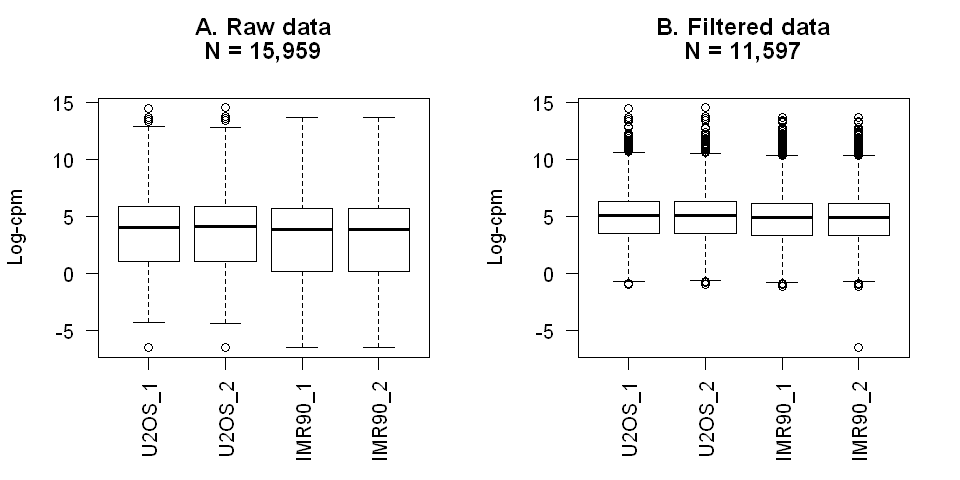

In [65]:
## Boxplots
par(mfrow=c(1,2))
options(repr.plot.width=8, repr.plot.height=4)

## Raw values
boxplot(lcpm, las=2)
title(main=paste(c("A. Raw data",paste('N =',format(nrow(x), big.mark=',')), sep='')), ylab="Log-cpm")

## Filtered values
boxplot(lcpm_filtered, las=2)
title(main=paste(c("B. Filtered data",paste('N =',format(nrow(x_filtered), big.mark=',')), sep='')), ylab="Log-cpm")

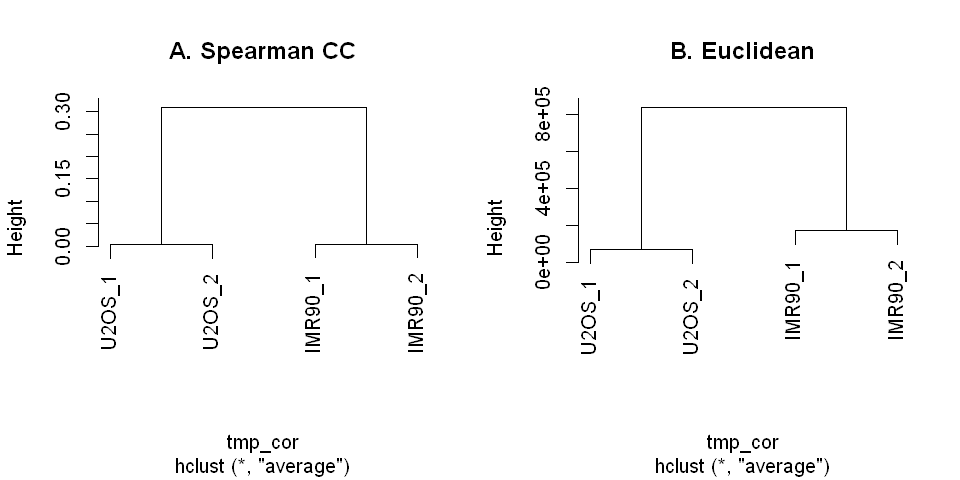

In [68]:
## Hierarchical clustering
par(mfrow=c(1,2))
options(repr.plot.width=8, repr.plot.height=4)

## Spearman CC
tmp_cor <- dist( 1 - cor(as.matrix(lcpm),method='spearman') )
tmp_clust <- hclust( tmp_cor, method="average")
plot(tmp_clust, main=paste("A. Spearman CC",sep=''))
#title(main=paste(c("A. SpearmanR",paste('N =',format(nrow(x_filtered), big.mark=',')), sep='')), ylab="Log-cpm")

## Euclidean Distance
tmp_cor <- dist( t(as.matrix(x_filtered)), method='euclidean' )
tmp_clust <- hclust( tmp_cor, method="average")
plot(tmp_clust, main=paste("B. Euclidean",sep=''))
#title(main=paste(c("B. Euclidean",paste('N =',format(nrow(x_filtered), big.mark=',')), sep='')), ylab="Log-cpm")

[1] "../../data/TissueMap/PRJNA347821_U2OS+IMR90.edgeR_cpm.txt"           
[2] "../../data/TissueMap/PRJNA347821_U2OS+IMR90.U2OS-IMR90.edgeR_out.txt"


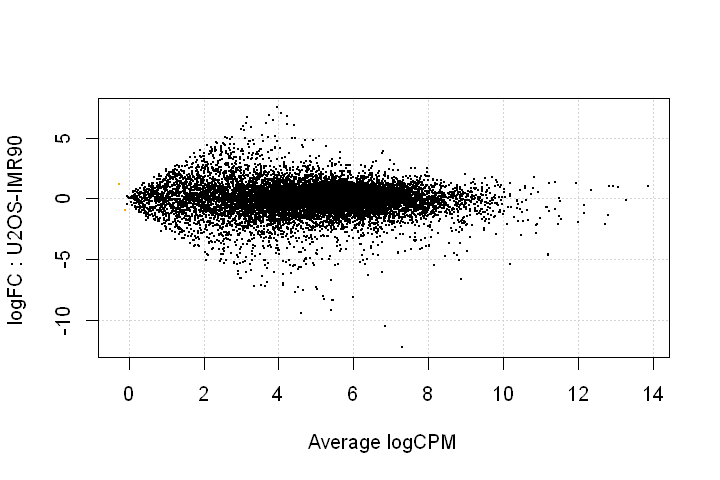

In [92]:
## EdgeR
library(edgeR)

y <- DGEList(counts=x_filtered,group=groups)
y <- calcNormFactors(y)
y <- estimateCommonDisp(y)
y <- estimateTagwiseDisp(y)

print( c(filename_edgeR_cpm, filename_edgeR_out) )
write.table(cpm(x_filtered), file=filename_edgeR_cpm, append=FALSE, row.names=TRUE, col.names=TRUE, sep='\t')
write.table(topTags(exactTest(y,pair=c(sample2,sample1)), n=Inf), file=filename_edgeR_out, append=FALSE, sep='\t')

par(mfrow=c(1,1))
options(repr.plot.width=6, repr.plot.height=4)
plotSmear(y, smooth.scatter=FALSE)

In [94]:
## LIMMMA
library(limma)
library(edgeR)

y <- DGEList(counts=x_filtered,group=groups)

design <- model.matrix( ~ 0 + as.factor(groups) )
v <- voom(y, design)

fit <- lmFit(v, design)
fit <- eBayes(fit, trend=TRUE)

write.table( topTable(fit, coef=ncol(design), confint=TRUE, n=Inf), file=filename_limma_out )